In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Data Preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

df.head(5)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[(df.dtypes != 'object') & (df.columns != 'converted')].index)

In [6]:
categorical_columns, numerical_columns

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [7]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
for c in categorical_columns:
    df.loc[:,c] = df[c].fillna('NA')

for c in numerical_columns:
    df.loc[:,c] = df[c].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

# Q1

What is the most frequent observation (mode) for the column `industry`?


In [10]:
df['industry'].mode()

0    retail
Name: industry, dtype: object

# Q2

Create the for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

In [11]:
df[numerical_columns].corr()

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.000000,0.009770,-0.023565,-0.004879
annual_income,0.009770,1.000000,0.027036,0.015610
interaction_count,-0.023565,0.027036,1.000000,0.009888
lead_score,-0.004879,0.015610,0.009888,1.000000


In [12]:
corr_matrix = df[numerical_columns].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

corr_matrix.where(~mask).stack().sort_values(ascending=False)

interaction_count  annual_income               0.027036
lead_score         annual_income               0.015610
                   interaction_count           0.009888
annual_income      number_of_courses_viewed    0.009770
lead_score         number_of_courses_viewed   -0.004879
interaction_count  number_of_courses_viewed   -0.023565
dtype: float64

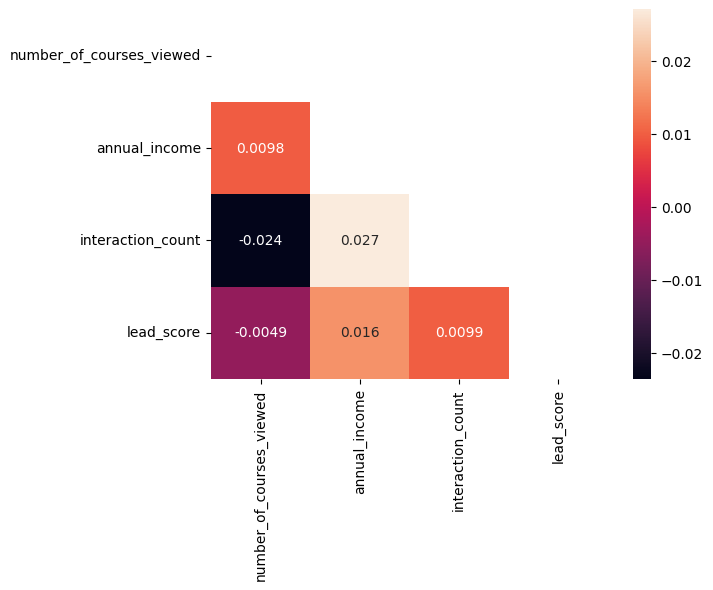

In [20]:
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.show()

# Split data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value `y` is not in your dataframe.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [23]:
df_train.shape, df_val.shape, df_test.shape

((876, 9), (293, 9), (293, 9))

In [24]:
y_train = df_train['converted'].to_numpy()
y_val = df_val['converted'].to_numpy()
y_test = df_test['converted'].to_numpy()

del df_train['converted']
del df_val['converted']
del df_test['converted']

# Q3

* Calculate the mutual information score between `y` and other categorical variables in the dataset. Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

In [25]:
from sklearn.metrics import mutual_info_score

for c in categorical_columns:
    print(f'{c}: {round(mutual_info_score(y_train, df_train[c]),2)}')

lead_source: 0.04
industry: 0.01
employment_status: 0.01
location: 0.0


# Q4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [26]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [27]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

y_pred_decision = (y_pred >= 0.5).astype(int)

accuracy = (y_pred_decision == y_val).mean()

print(f"val accuracy: {accuracy}")


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(np.concat([X_train, X_val]), np.concat([y_train, y_val]))
y_pred = model.predict_proba(X_test)[:, 1]

y_pred_decision = (y_pred >= 0.5).astype(int)

print(f"test accuracy: { (y_pred_decision == y_test).mean()}")


val accuracy: 0.6996587030716723
test accuracy: 0.7372013651877133


# Q5

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model using the same features and parameters as in Q4 (without rounding).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

In [28]:
features = categorical_columns + numerical_columns

for f in features:
    features_removed = [i for i in features if i != f]

    dv = DictVectorizer(sparse=False)

    train_dict = df_train[features_removed].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[features_removed].to_dict(orient='records')
    X_val = dv.fit_transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    y_pred_decision = (y_pred >= 0.5).astype(int)

    print(f"{f} is removed. Difference is {accuracy - (y_pred_decision == y_val).mean()}")

lead_source is removed. Difference is -0.0034129692832765013
industry is removed. Difference is 0.0
employment_status is removed. Difference is 0.0034129692832763903
location is removed. Difference is -0.010238907849829393
number_of_courses_viewed is removed. Difference is 0.14334470989761094
annual_income is removed. Difference is -0.15358361774744034
interaction_count is removed. Difference is 0.14334470989761094
lead_score is removed. Difference is -0.0068259385665528916


# Q6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter `C`: `[0.01, 0.1, 1, 10, 100]`.
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

for c in 0.01, 0.1, 1, 10, 100:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    y_pred_decision = (y_pred >= 0.5).astype(int)

    accuracy = (y_pred_decision == y_val).mean()

    print(f"{c}: {accuracy:0.10f}")

0.01: 0.6996587031
0.1: 0.6996587031
1: 0.6996587031
10: 0.6996587031
100: 0.6996587031
